In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/ef8d972e-d971-48d4-85b0-ca34297e6f3e.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_self_service_25_1697102647_2c6e43da_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/mackintosh_philosophy_dress_1697107181_db88f460_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_preloved_1697093176_9e6c7446_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_broken_white_1697080948_214d020a_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_preloved_1697087061_33470d8b_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_kaftan_gamis_longdress_1697101483_33485774_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dd262e49-9475-442f-aa1a-7eb21747ca24.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_preloved_1697096936_67aa608d_progressive_thumbnai

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 19.7 MB/s eta 0:00:0000:0100:01


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Folder setup
MAIN_DATASET_DIR = '/kaggle/input/clothes-dataset/Clothes_Dataset/'
ZARA_DIR = '/kaggle/input/zara-clothes-image-data/images/'

# Get main dataset paths & labels
img_paths = []
labels = []
for label in sorted(os.listdir(MAIN_DATASET_DIR)):
    class_dir = os.path.join(MAIN_DATASET_DIR, label)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                img_paths.append(os.path.join(class_dir, fname))
                labels.append(label)

# Get Zara image paths
zara_img_paths = [os.path.join(ZARA_DIR, fname) for fname in os.listdir(ZARA_DIR) if fname.lower().endswith(('jpg', 'jpeg', 'png'))]

print(f"Main dataset images: {len(img_paths)}")
print(f"Zara queries: {len(zara_img_paths)}")
import numpy as np
np.save("img_paths.npy", np.array(img_paths))
np.save("zara_img_paths.npy", np.array(zara_img_paths))

Main dataset images: 7500
Zara queries: 834


In [4]:
# Update filenames if you saved them elsewhere
features_efficientnet = np.load("/kaggle/input/just-models/features_efficientnet.npy")
zara_features_efficientnet = np.load("/kaggle/input/just-models/zara_features_efficientnet.npy")

features_convnext = np.load("/kaggle/input/just-models/features_convnext.npy")
zara_features_convnext = np.load("/kaggle/input/just-models/zara_features_convnext.npy")

features_vit = np.load("/kaggle/input/just-models/features_vit.npy")
zara_features_vit = np.load("/kaggle/input/just-models/zara_features_vit.npy")

features_clip = np.load("/kaggle/input/just-models/features_clip.npy")
zara_features_clip = np.load("/kaggle/input/just-models/zara_features_clip.npy")

In [5]:
import faiss

def get_topk_similarities(features, zara_features, img_paths, zara_img_paths, top_k=5):
    index = faiss.IndexFlatL2(features.shape[1])
    index.add(features)
    all_matches = []
    for i, zara_feat in enumerate(zara_features):
        D, I = index.search(zara_feat.reshape(1, -1), top_k)
        matched_paths = [img_paths[idx] for idx in I[0]]
        matched_distances = D[0]
        all_matches.append({
            'zara_image': zara_img_paths[i],
            'matches': matched_paths,
            'distances': matched_distances
        })
    return all_matches

In [6]:
def show_query_and_matches(query_img_path, match_img_paths, match_distances=None):
    n = len(match_img_paths)
    plt.figure(figsize=(3*(n+1), 4))
    plt.subplot(1, n+1, 1)
    plt.imshow(Image.open(query_img_path))
    plt.title("Zara Query")
    plt.axis('off')
    for i, img_path in enumerate(match_img_paths):
        plt.subplot(1, n+1, i+2)
        plt.imshow(Image.open(img_path))
        t = f"Match {i+1}"
        if match_distances is not None:
            t += f"\nDist: {match_distances[i]:.2f}"
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

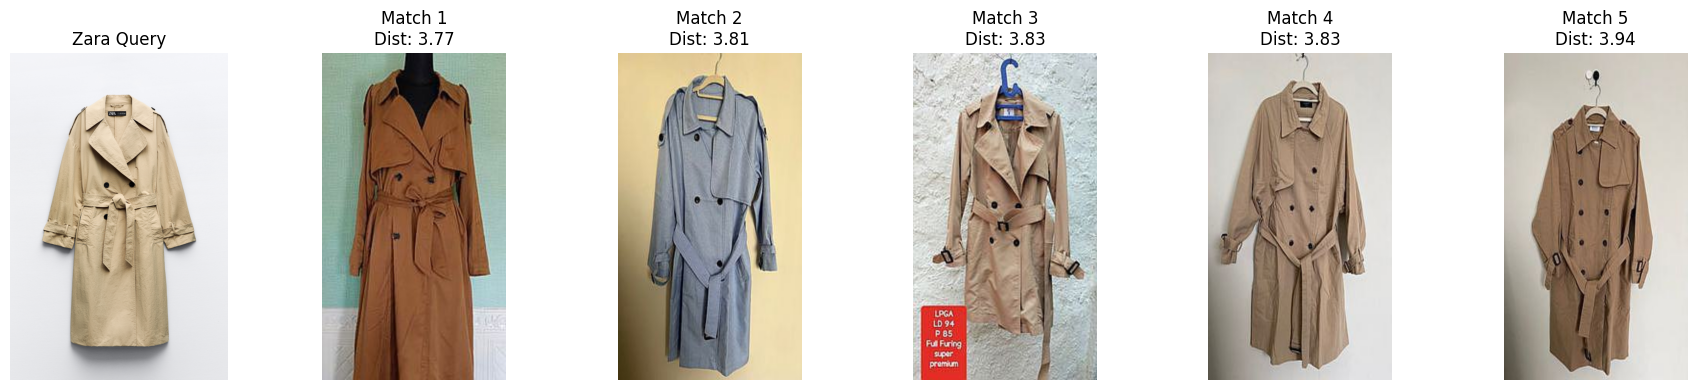

In [7]:
matches_efficientnet = get_topk_similarities(features_efficientnet, zara_features_efficientnet, img_paths, zara_img_paths)
show_query_and_matches(matches_efficientnet[0]['zara_image'], matches_efficientnet[0]['matches'], matches_efficientnet[0]['distances'])

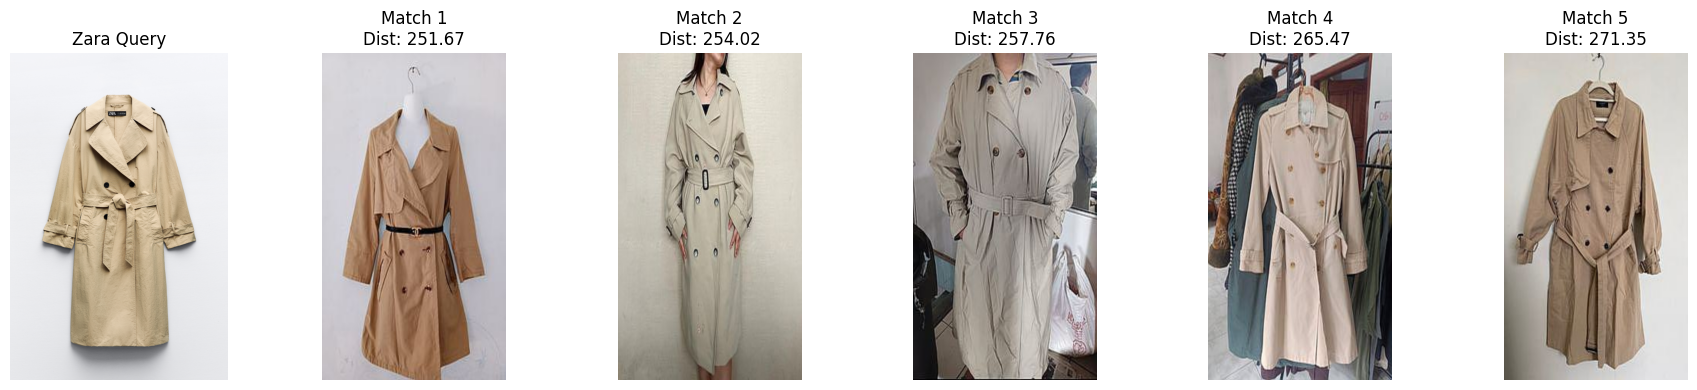

In [8]:
matches_convnext = get_topk_similarities(features_convnext, zara_features_convnext, img_paths, zara_img_paths)
show_query_and_matches(matches_convnext[0]['zara_image'], matches_convnext[0]['matches'], matches_convnext[0]['distances'])

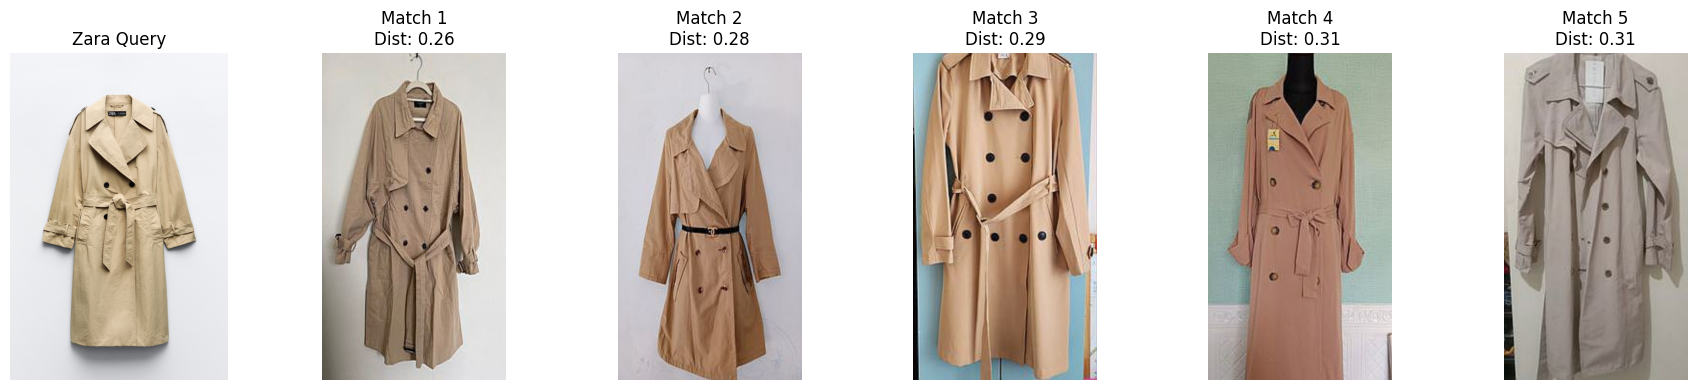

In [9]:
matches_vit = get_topk_similarities(features_vit, zara_features_vit, img_paths, zara_img_paths)
show_query_and_matches(matches_vit[0]['zara_image'], matches_vit[0]['matches'], matches_vit[0]['distances'])

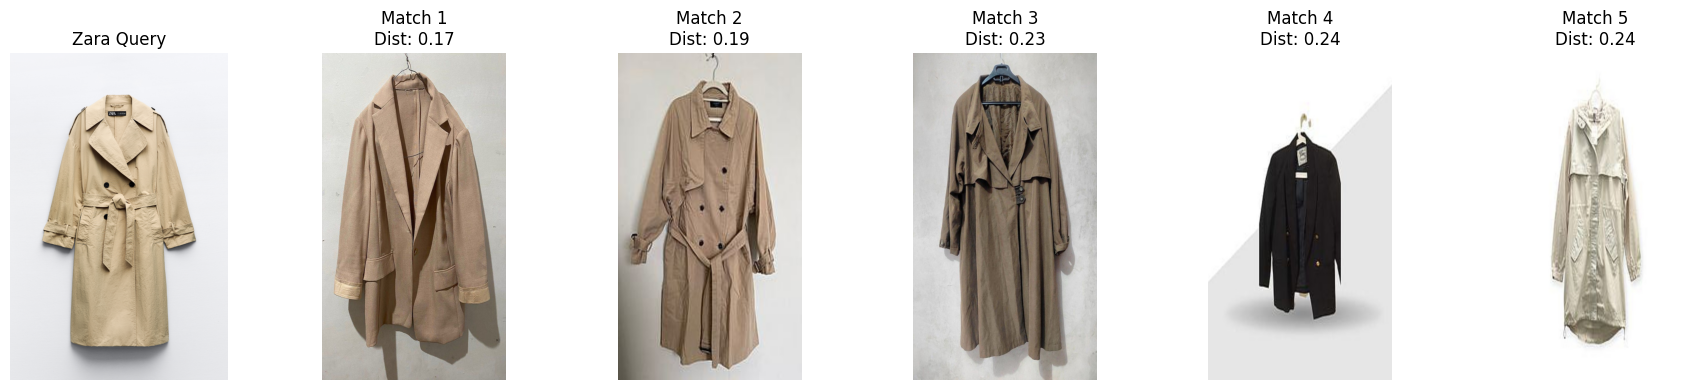

In [10]:
matches_clip = get_topk_similarities(features_clip, zara_features_clip, img_paths, zara_img_paths)
show_query_and_matches(matches_clip[0]['zara_image'], matches_clip[0]['matches'], matches_clip[0]['distances'])

In [11]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 35.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 118.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.1 MB/s eta 0:00:00


In [26]:
import gradio as gr
import numpy as np
import faiss
from PIL import Image
import os

# ----------------- Keras Models: EfficientNetV2L & ConvNeXtBase -----------------
from tensorflow.keras.applications import EfficientNetV2L, ConvNeXtBase
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

efficientnet_weights_path = "/kaggle/input/h5-models/efficientnetv2-l_notop.h5"
convnext_weights_path = "/kaggle/input/h5-models/convnext_base_notop.h5"

efficientnet_model = EfficientNetV2L(weights=None, include_top=False, pooling="avg")
efficientnet_model.load_weights(efficientnet_weights_path)

convnext_model = ConvNeXtBase(weights=None, include_top=False, pooling="avg")
convnext_model.load_weights(convnext_weights_path)

# ----------------- HuggingFace Transformers: ViT & CLIP -----------------
from transformers import ViTImageProcessor, ViTModel, CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# ViT
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

print("All models loaded and ready!")

# ----------------- CONFIGURATION -----------------
IMG_SIZE = (384, 384)  # Keras models
MODEL_OPTIONS = {
    "EfficientNetV2": (
        "/kaggle/input/just-models/features_efficientnet.npy",
        "/kaggle/working/img_paths.npy",
    ),
    "ConvNeXtBase": (
        "/kaggle/input/just-models/features_convnext.npy",
        "/kaggle/working/img_paths.npy",
    ),
    "ViT": (
        "/kaggle/input/just-models/features_vit.npy",
        "/kaggle/working/img_paths.npy",
    ),
    "CLIP": (
        "/kaggle/input/just-models/features_clip.npy",
        "/kaggle/working/img_paths.npy",
    ),
}

FEATURES_CACHE = {}
PATHS_CACHE = {}
INDEX_CACHE = {}

def load_model_features(model_name):
    features_file, img_paths_file = MODEL_OPTIONS[model_name]
    if model_name not in FEATURES_CACHE:
        features = np.load(features_file)
        img_paths = np.load(img_paths_file, allow_pickle=True).tolist()
        FEATURES_CACHE[model_name] = features
        PATHS_CACHE[model_name] = img_paths
        idx = faiss.IndexFlatL2(features.shape[1])
        idx.add(features)
        INDEX_CACHE[model_name] = idx
    return FEATURES_CACHE[model_name], PATHS_CACHE[model_name], INDEX_CACHE[model_name]

def extract_feature(query_img, model_name):
    # Preprocess the image for all models
    if model_name in ["EfficientNetV2", "ConvNeXtBase"]:
        img_resized = query_img.resize(IMG_SIZE)
        x = np.array(img_resized)
        if x.ndim == 2:
            x = np.stack([x]*3, axis=-1)
        x = np.expand_dims(x, axis=0)
    if model_name == "EfficientNetV2":
        x_proc = efficientnet_preprocess(x)
        feat = efficientnet_model.predict(x_proc, verbose=0).flatten()
    elif model_name == "ConvNeXtBase":
        x_proc = convnext_preprocess(x)
        feat = convnext_model.predict(x_proc, verbose=0).flatten()
    elif model_name == "ViT":
        img_vit = query_img.resize((224, 224))
        inputs = vit_processor(images=img_vit, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vit_model(**inputs)
            feats = outputs.pooler_output[0].cpu().numpy()
            feats = feats / np.linalg.norm(feats)
        feat = feats
    elif model_name == "CLIP":
        img_clip = query_img.resize((224, 224))
        inputs = clip_processor(images=img_clip, return_tensors="pt").to(device)
        with torch.no_grad():
            feats = clip_model.get_image_features(**inputs)[0].cpu().numpy()
            feats = feats / np.linalg.norm(feats)
        feat = feats
    else:
        feat = None
    return feat

def search_similar(uploaded_img, model_name, top_k):
    if uploaded_img is None:
        return ["No image uploaded."]
    features, img_paths, index = load_model_features(model_name)
    feat = extract_feature(uploaded_img, model_name)
    if feat is None:
        return ["Feature extraction failed."]
    D, I = index.search(feat.reshape(1, -1).astype("float32"), int(top_k))
    results = []
    for idx, dist in zip(I[0], D[0]):
        match_path = img_paths[idx]
        try:
            results.append((match_path, f"Distance: {dist:.2f}"))
        except Exception:
            results.append(("Image not found", f"Distance: {dist:.2f}"))
    return results

with gr.Blocks() as demo:
    gr.Markdown("# 👗 Fashion Image Similarity Search")
    gr.Markdown(
        "Upload any image, select a model, and see the most similar images from your Closet.<br>"
    )
    with gr.Row():
        query_img = gr.Image(type="pil", label="Upload Query Image")
        with gr.Column():
            model_name = gr.Dropdown(
                list(MODEL_OPTIONS.keys()), value="EfficientNetV2", label="Model"
            )
            top_k = gr.Slider(1, 10, value=5, step=1, label="Top K Matches")
            search_btn = gr.Button("Find Matches")
            output_gallery = gr.Gallery(label="Top Matches", columns=3, height="auto")
    
    def run_search(qimg, mname, k):
        return search_similar(qimg, mname, k)
    
    search_btn.click(run_search, inputs=[query_img, model_name, top_k], outputs=output_gallery)

demo.launch(allowed_paths=[
    "/kaggle/input/clothes-dataset/Clothes_Dataset",
    "/kaggle/input/just-models"
])


All models loaded and ready!
* Running on local URL:  http://127.0.0.1:7869
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://942676c4dad2316a3e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
